<a href="https://colab.research.google.com/github/harshitha-0531/DSA-programs/blob/main/day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

To download a dataset from Kaggle using `kagglehub`, you need the dataset identifier. You can find this in the URL of the dataset on Kaggle. For example, for the dataset at `https://www.kaggle.com/datasets/user/dataset-name`, the identifier is `user/dataset-name`.

You can then use the `kagglehub.dataset_download()` function to download the dataset.

In [ ]:
dataset_identifier = 'redwankarimsony/heart-disease-data'
dataset_path = kagglehub.dataset_download(dataset_identifier)
print(f"Dataset downloaded to: {dataset_path}")

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded to: /kaggle/input/heart-disease-data


In [ ]:
import os
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]

if len(csv_files) > 0:
    csv_file_path = os.path.join(dataset_path, csv_files[0])
    df = pd.read_csv(csv_file_path)
    display(df.head())
else:
    print(f"No CSV file found in the directory: {dataset_path}")

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


/tmp/ipython-input-532619134.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num', data=df, palette="Set2")


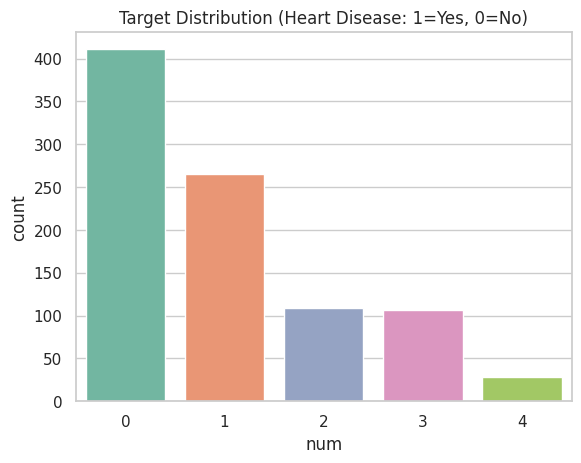

In [ ]:
sns.countplot(x='num', data=df, palette="Set2")
plt.title("Target Distribution (Heart Disease: 1=Yes, 0=No)")
plt.show()

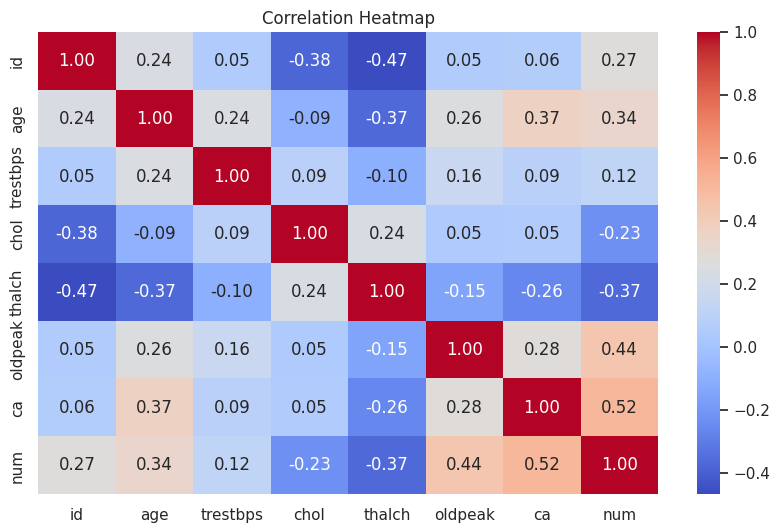

In [ ]:
plt.figure(figsize=(10,6))
# Select only numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
print("Columns:", df.columns)
if "target" in df.columns:
    y = df["target"]
elif "num" in df.columns:
    y = df["num"].apply(lambda x: 1 if x > 0 else 0)  # make binary
else:
    raise ValueError("Target column not found!")

X = df.drop(columns=[y.name])

Columns: Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [ ]:
numeric_cols = X.select_dtypes(include=[np.number]).columns
categorical_cols = X.select_dtypes(exclude=[np.number]).columns

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

In [ ]:
# --- Split data (stratify for balance) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
#  Logistic Regression
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=2000, solver='liblinear'))
])
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
acc_log=accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8641304347826086
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [ ]:
#  Random Forest
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5] }


In [ ]:
grid_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
y_pred_rf = grid_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Best RF Params:", grid_rf.best_params_)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Best RF Params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Random Forest Accuracy: 0.8913043478260869
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        82
           1       0.87      0.95      0.91       102

    accuracy                           0.89       184
   macro avg       0.90      0.88      0.89       184
weighted avg       0.89      0.89      0.89       184



In [ ]:
#  XGBoost
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='logloss', random_state=42))])
param_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.2]}

grid_xgb = GridSearchCV(xgb, param_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)
y_pred_xgb = grid_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("Best XGB Params:", grid_xgb.best_params_)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


Best XGB Params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
XGBoost Accuracy: 0.9021739130434783
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88        82
           1       0.88      0.96      0.92       102

    accuracy                           0.90       184
   macro avg       0.91      0.90      0.90       184
weighted avg       0.91      0.90      0.90       184



In [ ]:

results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [acc_log, acc_rf, acc_xgb]
})

print("\nModel Comparison:\n", results)





Model Comparison:
                  Model  Accuracy
0  Logistic Regression  0.864130
1        Random Forest  0.891304
2              XGBoost  0.902174
